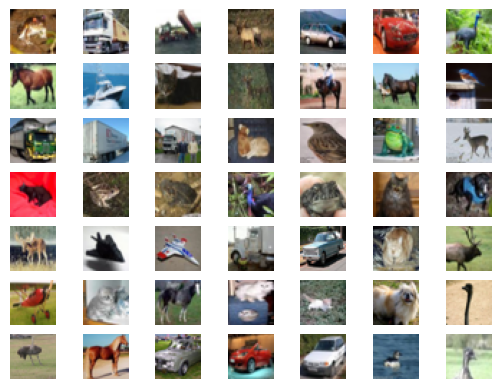

In [1]:
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot as plt

(xTrain, yTrain), (xTest, yTest) = load_data()

for i in range(49):
    plt.subplot(7, 7, i+1)
    plt.axis('off')
    plt.imshow(xTrain[i])
    
plt.show()


In [2]:
xTrain.shape

(50000, 32, 32, 3)

In [24]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def discriminator(in_shape=(32,32,3)):
    model = Sequential()
    
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    opt = Adam(learning_rate=0.002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

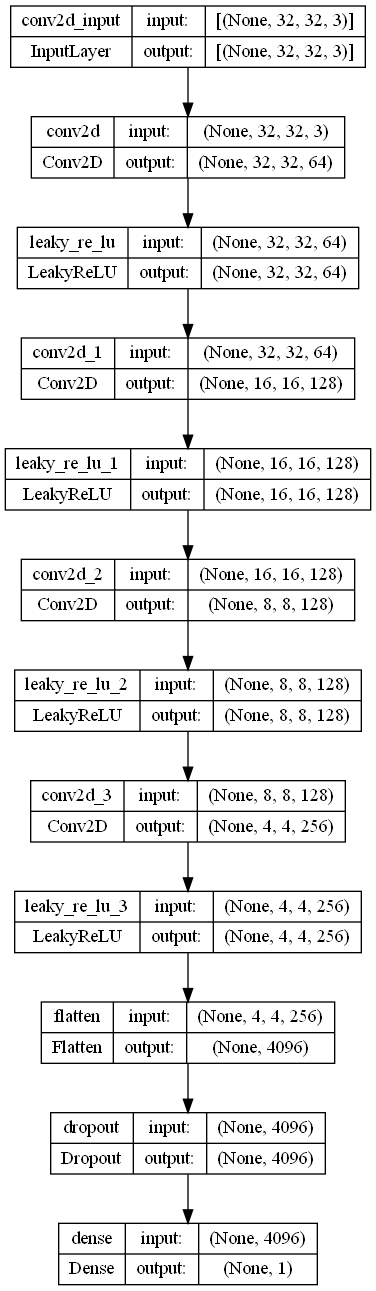

In [5]:
model = discriminator()
model.summary()
plot_model(model, to_file='discriminator_architecture.png', show_shapes=True, show_layer_names=True)

In [15]:
def generator(latent_dim):
    model = Sequential()
    
    model.add(Dense(4*4*256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    return model

In [16]:
def generate_latent_points(latent_dim, n_samples):    
    x_input = np.random.randn(latent_dim*n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [17]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    return X, np.zeros((n_samples, 1))

In [33]:
def load_real_samples():
    (xTrain, _), (_, _) = load_data()
    x = xTrain.astype('float32')
    x = (x-127.5)/127.5
    return x

In [34]:
dataset = load_real_samples()

In [18]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    return X, np.ones((n_samples, 1)) 

In [19]:
def gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    
    model.add(g_model)
    model.add(d_model)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_2 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


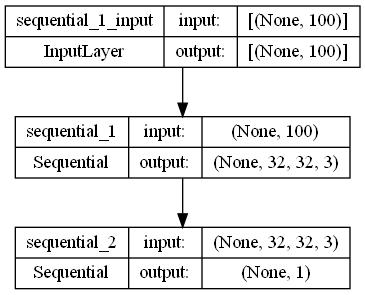

In [20]:
latent_dim = 100
g_model = generator(latent_dim)
d_model = discriminator()
gan_model = gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)


In [41]:
def train(gen_model, dis_model, gan_model, dataset, latent_dim, epoch=200, n_batch=128):
    bat_per_epo = int(dataset.shape[0]/n_batch)
    half_batch = int(n_batch/2)
    
    for i in range(epoch):
        for j in range(bat_per_epo):
            
            x_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(x_real, y_real)
            
            x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(x_fake, y_fake)
            
            x_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            
            g_loss = gan_model.train_on_batch(x_gan, y_gan)
            
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
            
            if(i+1) % 20 == 0:
                sum_performance(i, g_model, d_model, dataset, latent_dim)
            

In [42]:
def sum_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples = 150):
    x_real, y_real = generate_real_samples(dataset , n_samples)
    _, acc_real = d_model.evaluate(x_real, y_real, verbose=0)
    
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%' %(acc_real*100, acc_fake*100))
    
    save_plot(x_fake, epoch)
    filename='gen_mod_%03d.h5' %(epoch+1)
    g_model.save(filename)

In [43]:
def save_plot(ex, epoch, n=7):
    ex = (ex+1)/2.0
    for i in range(n*n):
        plt.subplot(n, n, 1+i)
        plt.axis('off')
        plt.imshow(ex[i])
        
    filename = 'gen_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [44]:
train(g_model, d_model, gan_model, dataset, latent_dim, epoch=200, n_batch=128)

2/2 [==============================] - 0s 63ms/step
>1, 1/390, d1=0.002, d2=0.643 g=0.953
2/2 [==============================] - 0s 68ms/step
>1, 2/390, d1=0.000, d2=0.401 g=2.632
2/2 [==============================] - 0s 76ms/step
>1, 3/390, d1=0.000, d2=0.016 g=6.596
2/2 [==============================] - 0s 75ms/step
>1, 4/390, d1=0.000, d2=0.001 g=8.690
2/2 [==============================] - 0s 73ms/step
>1, 5/390, d1=0.000, d2=0.001 g=7.989
2/2 [==============================] - 0s 54ms/step
>1, 6/390, d1=0.000, d2=0.060 g=17.590
2/2 [==============================] - 0s 51ms/step
>1, 7/390, d1=0.382, d2=0.012 g=2.302
2/2 [==============================] - 0s 54ms/step
>1, 8/390, d1=0.639, d2=15.838 g=0.998
2/2 [==============================] - 0s 68ms/step
>1, 9/390, d1=0.000, d2=3.205 g=6.432
2/2 [==============================] - 0s 68ms/step
>1, 10/390, d1=0.893, d2=0.004 g=4.939
2/2 [==============================] - 0s 67ms/step
>1, 11/390, d1=0.000, d2=0.018 g=4.441
2/2 [=

KeyboardInterrupt: 